In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines

text_width = 6.30107 # in  --> Confirmed with template explanation

fs_m1 = 6  # for figure ticks
fs = 8  # for regular figure text
fs_p1 = 9  # figure titles

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family':'sans-serif', 'sans-serif': ['Helvetica']})
matplotlib.rc('text', usetex=True)
plt.style.use(['paper.mplstyle'])

In [22]:
n_targets = 1
times = [300]
hand_targets = np.loadtxt(f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/random_monkeys_random_lambda_1E-7/mov_only_soc/hand_targets")
def get_dir(lam, t_coeff):
    return f"/home/mmcs3/rds/rds-t2-cs156-T7o4pEA8QoU/mmcs3/t_coeff_{t_coeff}/random_monkeys_random_lambda_{lam}/ramping/seed_1_200_2_1.5"

def hands(dir, i, t):
    idces = [0,2]
    h = np.loadtxt(f'{dir}/hands_{i}_{t}')[:,idces]
    return h - h[0]

def torques(dir, i, t):
    h = np.loadtxt(f'{dir}/torques_{i}_{t}')
    return h

def prep_idx(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def get_prep_idx(us, t):
        if t == 0:
            return 0
        else : 
            cutoff = int(t/2 )
            u_prep, u_mov = us[:cutoff+1], us[cutoff+1:]
            return np.sum(u_prep**2)/np.sum(u_mov**2)
    def us(t,i):
        return np.loadtxt(f"{dir}/us_{i}_{t}")
    def get_all_idces(i):
        ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def input_amount(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def get_prep_idx(us, t):
        return np.sum(us**2)
    def us(t,i):
        return np.loadtxt(f"{dir}/us_{i}_{t}")
    def get_all_idces(i):
        ai = np.asarray([get_prep_idx(us(t, i),t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_u(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def cost_u(t, i):
       return np.loadtxt(f'{dir}/u_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_u(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(8)
    return m, v

def cost_tgt(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def cost_tgt(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[-1]
    def get_all_idces(i):
        ai = np.asarray([cost_tgt(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def cost_torques(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/task_cost_{i}_{t}')[0]
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def mv_loss(lam, t_coeff= 1.5):
    dir = get_dir(lam, t_coeff)
    def cost_torques(t, i):
       return np.loadtxt(f'{dir}/loss_{i}_{t}').sum()
    def get_all_idces(i):
        ai = np.asarray([cost_torques(t,i) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def successful_reach(lam, t_coeff=1.5):
    dir = get_dir(lam, t_coeff)
    def get_mov_time(mov, tgt):
        end_pos = mov[-100:,:2]
        end_diff = np.linalg.norm(end_pos - tgt, axis=1)
        failures = np.sum(np.where(end_diff> 0.01, 1., 0.))
        return failures
    def get_all_idces(i):
        tgt = hand_targets[i]
        ai = np.asarray([get_mov_time(hands(dir, i, t), tgt) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

def successful_hold(lam, t_coeff=1.5):
    dir = get_dir(lam, t_coeff)
    def get_torques_prep(i, t):
        max_t = np.max(np.linalg.norm(torques(dir, i, t), axis=1))
        torques_prep = torques(dir, i, t)[:int(t/2),:]
        diff = np.linalg.norm(torques_prep, axis=1)
        failures = np.sum(np.where(diff> 0.01*max_t, 1., 0.))
        return failures
    def get_all_idces(i):
        tgt = hand_targets[i]
        ai = np.asarray([get_torques_prep(i,t) for t in times])
        return ai
    movs = range(n_targets)
    idces = np.concatenate([get_all_idces(i)[:,None] for i in movs], axis=1)
    m, v = np.mean(idces, axis=1), np.std(idces, axis=1)/np.sqrt(n_targets)
    return m, v

In [23]:
t_coeff = "1.5" 
lam = "0.0001"
m_loss, _ =  mv_loss(lam, t_coeff)
sr, _ = successful_reach(lam, t_coeff)
sh, _ = successful_hold(lam, t_coeff)





## Add a heatmap of what happens for different parameters

In [26]:
t_coeffs = ["1.", '10.', "50."]
lambdas = ["0.001", "0.0001", "0.00001",  "0.000001", "0.0000001"]
srs = []
shs = []
pis = []
losses = []
tot_us = []
for tc in t_coeffs :
    srts, shts, pits, losses_ts, tot_uts = [], [], [], [], []
    for lam in lambdas : 
        sr, _ = successful_reach(lam, tc)
        sh, _ = successful_hold(lam, tc)
        pi, _ = prep_idx(lam, tc)
        ml, _ = mv_loss(lam, tc)
        tot_u, _ = input_amount(lam, tc)
        srts += [sr]
        shts += [sh]
        pits += [pi]
        losses_ts += [ml]
        tot_uts += [tot_u]
    srs += [srts]
    shs += [shts]
    pis += [pits]
    losses += [losses_ts]
    tot_us += [tot_uts]
srs = np.asarray(srs)[:,:,-1]
shs = np.asarray(shs)[:,:,-1]
pis = np.asarray(pis)[:,:,-1]
losses = np.asarray(losses)[:,:,-1]
tot_us = np.asarray(tot_us)[:,:,-1]

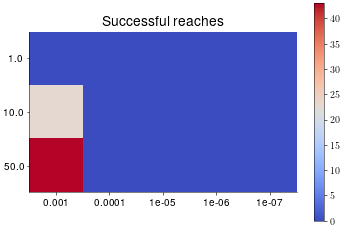

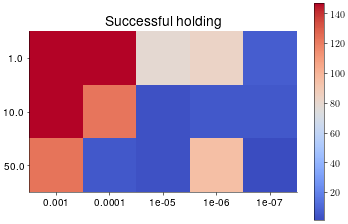

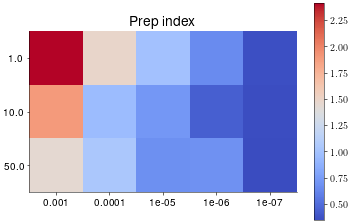

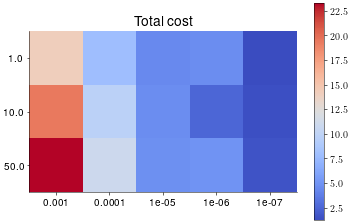

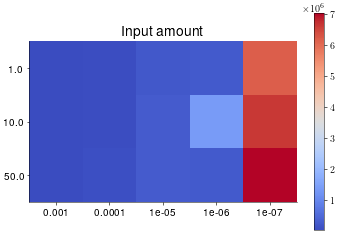

In [28]:
## Successful reach?
plt.imshow(srs, cmap = "coolwarm")
plt.title("Successful reaches")
plt.colorbar()
ax = plt.gca()
ax.set_xticks(range(len(lambdas)), [float(l) for l in lambdas])
ax.set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs])
## Successful hold?
plt.figure()
plt.imshow(shs, cmap = "coolwarm")
plt.colorbar()
plt.title("Successful holding")
ax = plt.gca()
ax.set_xticks(range(len(lambdas)), [float(l) for l in lambdas])
ax.set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs])
## Prep index?
plt.figure()
plt.imshow(pis, cmap = "coolwarm")
plt.colorbar()
plt.title("Prep index")
ax = plt.gca()
ax.set_xticks(range(len(lambdas)), [float(l) for l in lambdas])
ax.set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs])
## Loss
plt.figure()
plt.imshow(losses, cmap = "coolwarm")
plt.colorbar()
plt.title("Total cost")
ax = plt.gca()
ax.set_xticks(range(len(lambdas)), [float(l) for l in lambdas])
ax.set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs])
## Input amount
plt.figure()
plt.imshow(tot_us, cmap = "coolwarm")
plt.colorbar()
plt.title("Input amount")
ax = plt.gca()
ax.set_xticks(range(len(lambdas)), [float(l) for l in lambdas])
ax.set_yticks(range(len(t_coeffs)), [float(t) for t in t_coeffs])